<a href="https://colab.research.google.com/github/chenyuwaa/datasci_223/blob/main/223_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd

# Path to the folder containing the CSV files in your Google Drive
folder_path = '/content/drive/My Drive/223 final project input/'

# List all files in the folder
files = os.listdir(folder_path)

In [4]:
pip install heartpy

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
import math
from sklearn.neighbors import KNeighborsClassifier
import heartpy as hp
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [6]:
annotations_train = ['gamer1-annotations.csv', 'gamer2-annotations.csv', 'gamer3-annotations.csv', 'gamer4-annotations.csv']
ppg_train = ['gamer1-ppg-2000-01-01.csv', 'gamer1-ppg-2000-01-02.csv','gamer2-ppg-2000-01-01.csv', 'gamer2-ppg-2000-01-02.csv','gamer3-ppg-2000-01-01.csv', 'gamer3-ppg-2000-01-02.csv', 'gamer4-ppg-2000-01-01.csv', 'gamer4-ppg-2000-01-02.csv']

In [7]:
# returns dataframe of ppg signal based on filename (file from 223 final project input folder)
# removes non-finite values
# moving average filter

def read_ppg(filename):
    df = pd.read_csv('/content/drive/My Drive/223 final project input/' + filename)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    df.astype({'Red_Signal': 'int64'}).dtypes
    df.Red_Signal.rolling(50, min_periods=1).mean() # moving average
    return df["Red_Signal"]

In [8]:
# returns dataframe of selected features from the heartpy processing result removing NaN values

def pick_features(all_measures, selected):
    x_train = []
    for i in range(len(all_measures['bpm'])):
        row = []
        for cat in selected:
            value = all_measures[cat][i]
            row.append(remove_nan(value))
        x_train.append(row)
    return x_train


In [9]:
# if value is NaN return 0 else returns value

def remove_nan(value):
    if math.isnan(value):
        return 0
    return value

In [10]:
# filters and processes ppg dataframe with heartpy

def process_ppg(data):
    sr = 100
    filtered = hp.filter_signal(data, [0.5, 15], sample_rate=sr, order=3, filtertype='bandpass')

    working_data, measures = hp.process_segmentwise(filtered, sample_rate=sr, segment_width=40, segment_overlap=0.25, segment_min_size=30)
    return  working_data, measures

In [11]:
 def x_data(filename, selected_features):

    data = read_ppg(filename)

    working_data, measures = process_ppg(data)

    return pick_features(measures, selected_features)

In [12]:
def y_data(filename, size):
    data = []
    sleepiness = []
    with open('/content/drive/My Drive/223 final project input/' + filename) as file:
        file.readline()
        for row in file:
            time, event, value = row.strip().split(',', 2)
            if event == 'Stanford Sleepiness Self-Assessment (1-7)':
                value = int(value)
                if value < 4:
                    sleepiness.append(0)
                else:
                    sleepiness.append(1)

    for i in range(len(sleepiness)):
        data = data + [sleepiness[i]] * math.ceil(size/25)

    return data[:size]

In [13]:
def read_gamer(x_file1, x_file2, y_file, features):
    x_result = x_data(x_file1, features)
    x_result = np.concatenate((x_result, x_data(x_file2, features)), axis=0)
    y_result = y_data(y_file, len(x_result))
    return x_result, y_result

# Reading data

In [14]:
features = ['bpm', 'ibi', 'breathingrate']

**Training data**

In [15]:
x_train = []
y_train = []

for i in range(4):
    x, y = read_gamer(ppg_train[i*2], ppg_train[i*2+1], annotations_train[i], features)

    for line in x:
        x_train.append(line)
    y_train = y_train + y

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:5329: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: 

In [16]:
# Oversample imbalanced dataset with SMOTE
counter_original = Counter(y_train)
print(counter_original)


# oversampling the dataset

oversample = SMOTE(sampling_strategy=0.35)
x_over, y_over = oversample.fit_resample(x_train, y_train)
x_train, y_train = x_over, y_over


# undersampling (gave worse results)

#undersample = RandomUnderSampler(sampling_strategy=0.5)
#x_under, y_under = undersample.fit_resample(x_train, y_train)
#x_train, y_train = x_under, y_under

counter = Counter(y_train)
print(counter)

Counter({0: 6562, 1: 1714})
Counter({0: 6562, 1: 2296})


**Test data**

In [17]:
x_test, y_test = read_gamer('gamer5-ppg-2000-01-01.csv', 'gamer5-ppg-2000-01-02.csv', 'gamer5-annotations.csv', features)

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has bee

**Visualisation**

Text(0.5, 1.0, 'After SMOTE')

<Figure size 640x480 with 0 Axes>

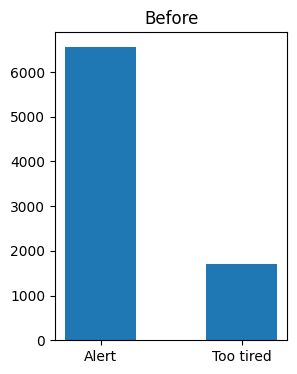

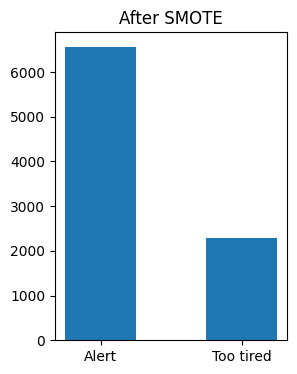

In [18]:
plt.figure(1)
fig = plt.figure(figsize = (3, 4))
plt.bar(['Alert', 'Too tired'], counter_original.values(), width=0.5)
plt.title("Before")

plt.figure(2)
fig = plt.figure(figsize = (3, 4))
plt.bar(['Alert', 'Too tired'], counter.values(), width=0.5)
plt.title("After SMOTE")

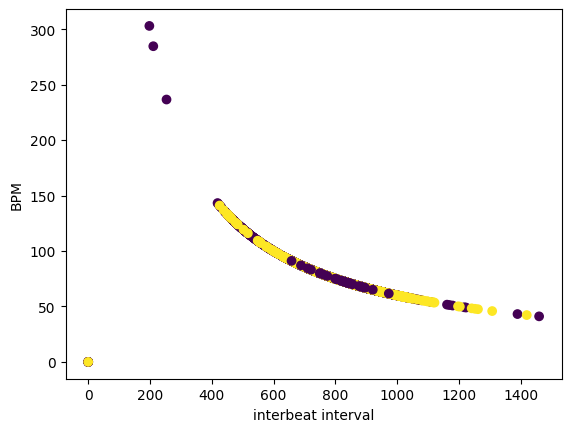

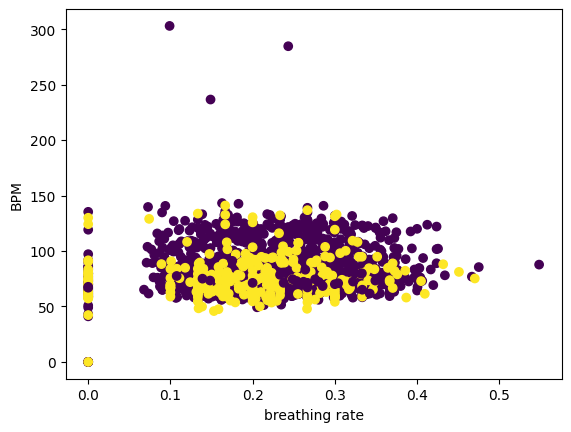

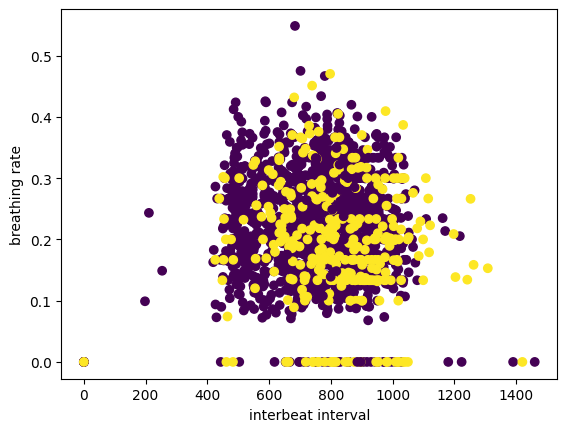

In [19]:
bpm = []
ibi = []
breath = []

for row in x_train[:2000]:
    bpm.append(row[0])
    ibi.append(row[1])
    breath.append(row[2])

plt.figure(1)
plt.scatter(ibi, bpm, c=y_train[:2000])
plt.xlabel('interbeat interval')
plt.ylabel('BPM')

plt.figure(2)
plt.scatter(breath, bpm, c=y_train[:2000])
plt.xlabel('breathing rate')
plt.ylabel('BPM')

plt.figure(3)
plt.scatter(ibi, breath, c=y_train[:2000])
plt.xlabel('interbeat interval')
plt.ylabel('breathing rate')

plt.show()

<Axes: >

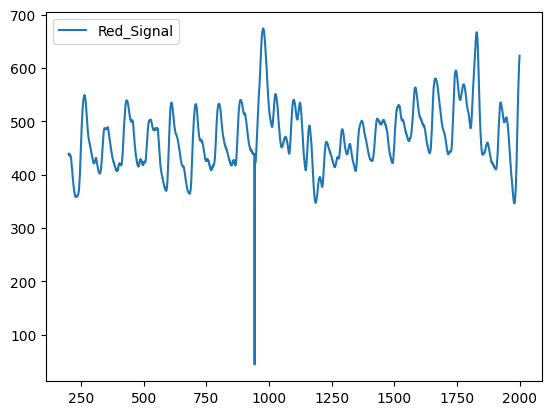

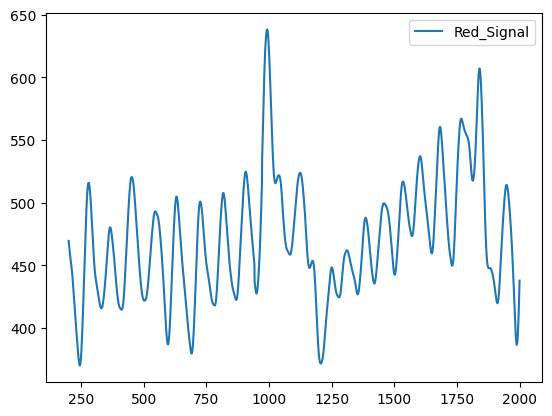

In [20]:
# Moving average
df_ppg1_1 = pd.read_csv('/content/drive/My Drive/223 final project input/gamer1-ppg-2000-01-01.csv', encoding='utf-8')
clean1_1 = df_ppg1_1.copy()
clean1_1['Red_Signal'] = df_ppg1_1.Red_Signal.rolling(30, min_periods=1).mean()

df_ppg1_1.iloc[200:2000].plot()
clean1_1.iloc[200:2000].plot()

(230.0, 250.0)

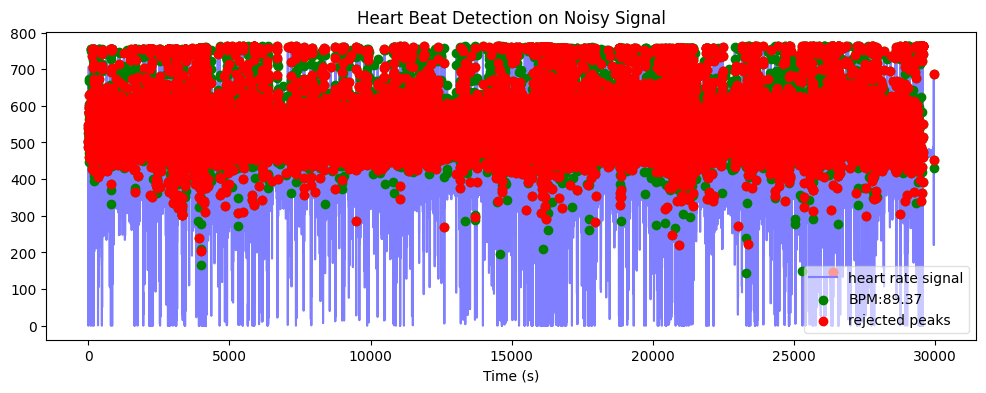

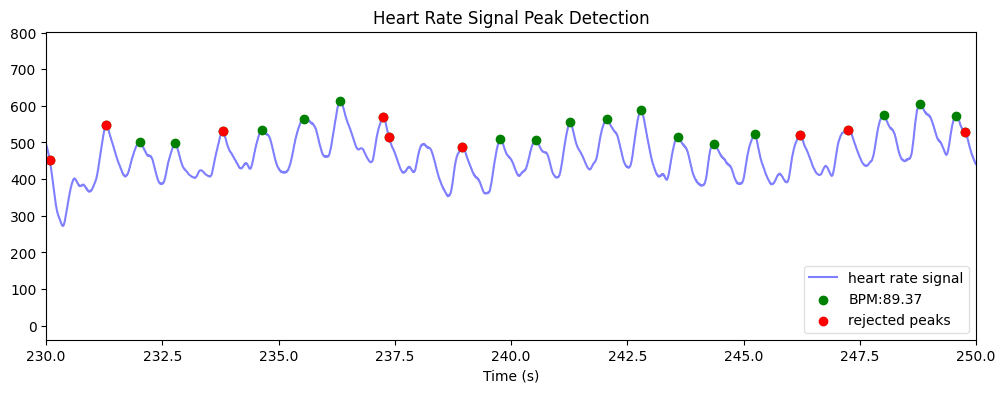

In [21]:
hrdata = hp.get_data('/content/drive/My Drive/223 final project input/gamer1-ppg-2000-01-01.csv', column_name='Red_Signal')
working_data, measures = hp.process(hrdata, sample_rate=100)
hp.plotter(working_data, measures, title='Heart Beat Detection on Noisy Signal', figsize=(12,4))

#zoomed in
hp.plotter(working_data, measures, figsize=(12,4))
plt.xlim(230, 250)

# Classification algorithms

In [22]:
algorithms = ['Decision tree', 'Random forest', 'KNN', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes']

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [24]:
dt = DecisionTreeClassifier(criterion='gini', max_depth = 3, random_state=8).fit(x_train, y_train)

In [25]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=0).fit(x_train, y_train)

In [26]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

In [27]:
gnb = GaussianNB().fit(x_train, y_train)

In [28]:
mnb = MultinomialNB().fit(x_train, y_train)

In [29]:
models = [dt, rf, knn, gnb, mnb]

In [30]:
accuracy_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1-score'])
results = []


for i in range(len(models)):
    prediction = models[i].predict(x_test)

    print(algorithms[i], "confusion matrix")
    print(confusion_matrix(y_test, prediction))

    recall = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    acc = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'model': [algorithms[i]], 'accuracy': [acc], 'precision' : [precision], 'recall' : [recall], 'f1-score' : [f1]})], ignore_index=True)

print(accuracy_df)

Decision tree confusion matrix
[[2068    0]
 [ 277    1]]
Random forest confusion matrix
[[2026   42]
 [ 274    4]]
KNN confusion matrix
[[2032   36]
 [ 272    6]]
Gaussian Naive Bayes confusion matrix
[[2068    0]
 [ 278    0]]
Multinomial Naive Bayes confusion matrix
[[2047   21]
 [ 268   10]]
                     model  accuracy  precision    recall  f1-score
0            Decision tree  0.881927   1.000000  0.003597  0.007168
1            Random forest  0.865303   0.086957  0.014388  0.024691
2                      KNN  0.868713   0.142857  0.021583  0.037500
3     Gaussian Naive Bayes  0.881500   0.000000  0.000000  0.000000
4  Multinomial Naive Bayes  0.876812   0.322581  0.035971  0.064725


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
counter = Counter(y_test)
print(counter)

Counter({0: 2068, 1: 278})


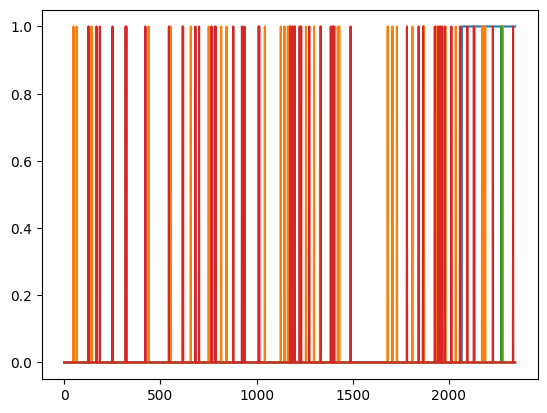

In [32]:
plt.plot(y_test)
plt.plot(knn.predict(x_test))
plt.plot(dt.predict(x_test))
plt.plot(rf.predict(x_test))

# Neural Network

In [33]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

In [34]:
classifier = Sequential()
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))

classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fitting the Neural Network on the training data
classifier.fit(np.array(x_train),np.array(y_train), batch_size=15 , validation_split=0.2, shuffle=True, epochs=10, verbose=1)

Epoch 1/10
473/473 [==============================] - 3s 3ms/step - loss: 0.5034 - accuracy: 0.8031 - val_loss: 0.8592 - val_accuracy: 0.4791
Epoch 2/10
473/473 [==============================] - 1s 3ms/step - loss: 0.4939 - accuracy: 0.8062 - val_loss: 0.9587 - val_accuracy: 0.4791
Epoch 3/10
473/473 [==============================] - 1s 3ms/step - loss: 0.4942 - accuracy: 0.8062 - val_loss: 0.9720 - val_accuracy: 0.4791
Epoch 4/10
473/473 [==============================] - 1s 3ms/step - loss: 0.4943 - accuracy: 0.8062 - val_loss: 0.9699 - val_accuracy: 0.4791
Epoch 5/10
473/473 [==============================] - 1s 2ms/step - loss: 0.4935 - accuracy: 0.8062 - val_loss: 0.9362 - val_accuracy: 0.4791
Epoch 6/10
473/473 [==============================] - 1s 2ms/step - loss: 0.4943 - accuracy: 0.8062 - val_loss: 0.9934 - val_accuracy: 0.4791
Epoch 7/10
473/473 [==============================] - 1s 3ms/step - loss: 0.4939 - accuracy: 0.8062 - val_loss: 0.9602 - val_accuracy: 0.4791
Epoch 

In [35]:
acc = classifier.evaluate(np.array(x_test), np.array(y_test))
print(acc)

74/74 [==============================] - 0s 2ms/step - loss: 0.3918 - accuracy: 0.8815
[0.3918284475803375, 0.8815004229545593]


In [36]:
classifier2 = Sequential()
classifier2.add(Dense(units=12,kernel_initializer='uniform', activation='tanh'))

classifier2.add(Dense(units=9,activation='sigmoid'))

classifier2.add(Dense(units=6,activation='sigmoid'))

classifier2.add(Dense(units=3,activation='sigmoid'))

classifier2.add(Dense(units=1, activation='sigmoid'))

classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fitting the Neural Network on the training data
classifier2.fit(np.array(x_train),np.array(y_train), batch_size=7 , shuffle=True, epochs=10, verbose=1)

Epoch 1/10
1266/1266 [==============================] - 4s 2ms/step - loss: 0.5751 - accuracy: 0.7408
Epoch 2/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5725 - accuracy: 0.7408
Epoch 3/10
1266/1266 [==============================] - 4s 3ms/step - loss: 0.5724 - accuracy: 0.7408
Epoch 4/10
1266/1266 [==============================] - 4s 3ms/step - loss: 0.5725 - accuracy: 0.7408
Epoch 5/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5724 - accuracy: 0.7408
Epoch 6/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5724 - accuracy: 0.7408
Epoch 7/10
1266/1266 [==============================] - 4s 3ms/step - loss: 0.5724 - accuracy: 0.7408
Epoch 8/10
1266/1266 [==============================] - 4s 3ms/step - loss: 0.5725 - accuracy: 0.7408
Epoch 9/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5725 - accuracy: 0.7408
Epoch 10/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.572

In [37]:
classifier2.predict(np.array(x_test))

74/74 [==============================] - 0s 2ms/step


array([[0.25198385],
       [0.25198385],
       [0.25198385],
       ...,
       [0.25198385],
       [0.25198385],
       [0.25198385]], dtype=float32)

In [38]:

#recall = recall_score(y_test, prediction)
#precision = precision_score(y_test, prediction)
acc = classifier2.evaluate(np.array(x_test), np.array(y_test))
#f1 = f1_score(y_test, prediction)
#accuracy_df = results_df.append({'model': 'NN2', 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1_score' : f1}, ignore_index=True)


74/74 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.8815
